# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15098706151826385966
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15628862668880629874
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Sat Dec 18 06:57:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    33W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'ResNet50'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 3
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1", "S2"
T_all_labels = "T0", "T1", "T2"

#base_path = ''
base_path = 'gdrive/My Drive/Research_3_2_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_ResNet50_None S_ResNet50_imagenet T_ResNet50_None T_ResNet50_imagenet


['S_ResNet50_imagenet',
 'S_ResNet50_None',
 'T_ResNet50_imagenet',
 'T_ResNet50_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1440, 128, 128, 3) (1440, 1)
(480, 128, 128, 3) (480, 1)
(480, 128, 128, 3) (480, 1)

(1920, 128, 128, 3) (1920, 1)
(640, 128, 128, 3) (640, 1)
(640, 128, 128, 3) (640, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1440, 128, 128, 3) (1440, 3)
(480, 128, 128, 3) (480, 3)
(480, 128, 128, 3) (480, 3)

(1920, 128, 128, 3) (1920, 3)
(640, 128, 128, 3) (640, 3)
(640, 128, 128, 3) (640, 3)


## 2-2. Image Check

xTrain_S image Numbers :  1440
xTrain_S image Numbers // 10 :  144
10


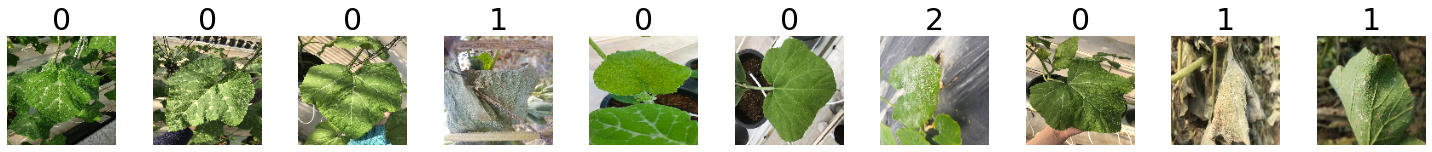

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  1920
xTrain_S image Numbers // 10 :  192
10


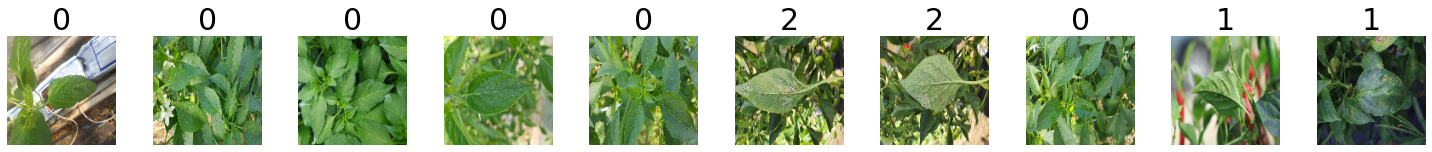

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.ResNet50 (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.ResNet50 (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 18s 202ms/step - loss: 0.9858 - accuracy: 0.6264 - val_loss: 1.6625 - val_accuracy: 0.5000
Epoch 2/100
23/23 [==============================] - 3s 135ms/step - loss: 0.3434 - accuracy: 0.8924 - val_loss: 1.6546 - val_accuracy: 0.2500
Epoch 3/100
23/23 [==============================] - 3s 134ms/step - loss: 0.1843 - accuracy: 0.9354 - val_loss: 1.8637 - val_accuracy: 0.2500
Epoch 4/100
23/23 [==============================] - 3s 135ms/step - loss: 0.1012 - accuracy: 0.9708 - val_loss: 2.5011 - val_accuracy: 0.4021
Epoch 5/100
23/23 [==============================] - 3s 134ms/step - loss: 0.0805 - accuracy: 0.9688 - val_loss: 2.8712 - val_accuracy: 0.2500
Epoch 6/100
23/23 [==============================] - 3s 134ms/step - loss: 0.0758 - accuracy: 0.9736 - val_loss: 3.6725 - val_accuracy: 0.2500
Epoch 7/100
23/23 [==============================] - 3s 134ms/step - loss: 0.0543 - accuracy: 0.9840 - val_loss: 4.5243 - val_accuracy: 0.250

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.985790,0.626389,1.662530,0.500000
1,0.343420,0.892361,1.654618,0.250000
2,0.184256,0.935417,1.863652,0.250000
3,0.101234,0.970833,2.501135,0.402083
4,0.080476,0.968750,2.871243,0.250000
...,...,...,...,...
66,0.001753,0.999306,0.305056,0.922917
67,0.001645,0.999306,0.380282,0.912500
68,0.002854,0.999306,0.192404,0.952083
69,0.012377,0.995833,0.590047,0.870833


Minimum validation loss: 0.12583200633525848
Maximum validation accuracy: 0.9645833373069763


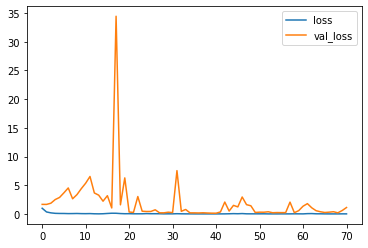

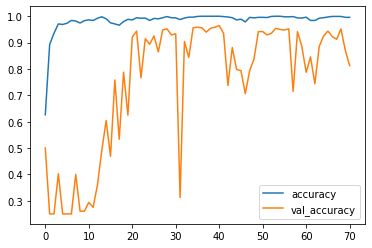

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
15/15 [==============================] - 1s 27ms/step - loss: 0.0677 - accuracy: 0.9812
test loss, test acc: [0.06768157333135605, 0.981249988079071]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

15/15 [==============================] - 1s 23ms/step


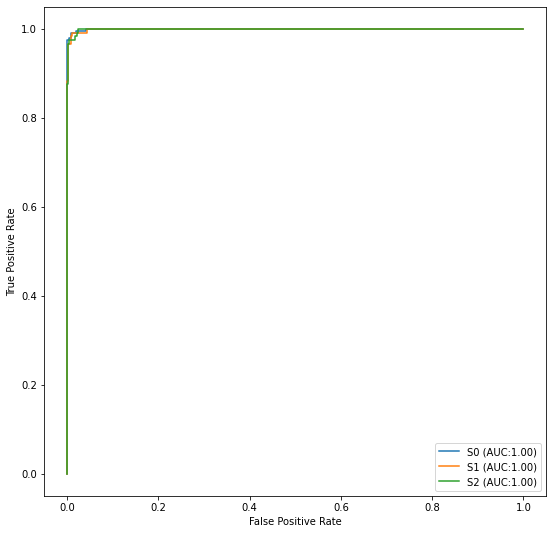

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

94781440/94765736 [==============================] - 0s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 9s 186ms/step - loss: 0.2190 - accuracy: 0.9215 - val_loss: 972.6491 - val_accuracy: 0.2500
Epoch 2/100
23/23 [==============================] - 3s 135ms/step - loss: 0.0870 - accuracy: 0.9743 - val_loss: 2883.2712 - val_accuracy: 0.2500
Epoch 3/100
23/23 [==============================] - 3s 136ms/step - loss: 0.0500 - accuracy: 0.9882 - val_loss: 115.3430 - val_accuracy: 0.2500
Epoch 4/100
23/23 [==============================] - 3s 136ms/step - loss: 0.0211 - accuracy: 0.9972 - val_loss: 1.9386 - val_accuracy: 0.2500
Epoch 5/100
23/23 [==============================] - 3s 136ms/step - loss: 0.0493 - accuracy: 0.9875 - val_loss: 22.4564 - val_accuracy: 0.2500
Epoch 6/100
23/23 [==============================] - 3s 135ms/step - loss: 0.0832 - accuracy: 0.9896 - val_loss: 207.9566 - val_accuracy: 0.2500
Epoch 7/100
23/23 [==============================] - 3s 141ms/step - loss: 0.1065 - accuracy: 0.9743 - val_loss: 3043.1956 - val_acc

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.219040,0.921528,972.649109,0.250000
1,0.087042,0.974306,2883.271240,0.250000
2,0.049987,0.988194,115.343018,0.250000
3,0.021051,0.997222,1.938591,0.250000
4,0.049278,0.987500,22.456434,0.250000
...,...,...,...,...
75,0.014151,0.995833,1.658225,0.822917
76,0.023556,0.990972,1.404083,0.795833
77,0.012964,0.997222,0.751413,0.904167
78,0.006988,0.997222,0.044085,0.983333


Minimum validation loss: 0.03336296230554581
Maximum validation accuracy: 0.9958333373069763


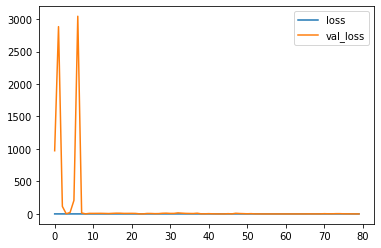

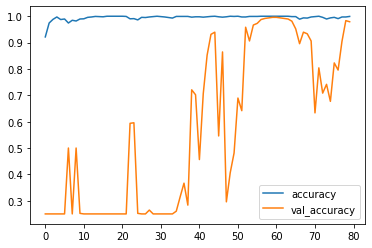

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
15/15 [==============================] - 1s 26ms/step - loss: 0.0481 - accuracy: 0.9896
test loss, test acc: [0.048067107796669006, 0.9895833134651184]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

15/15 [==============================] - 1s 23ms/step


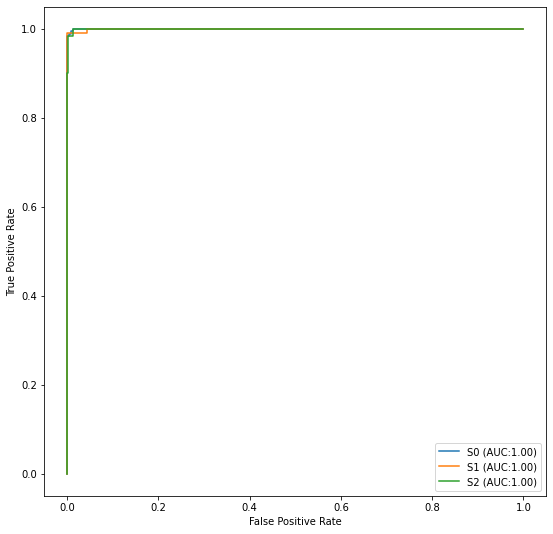

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 10s 178ms/step - loss: 1.0602 - accuracy: 0.5995 - val_loss: 1.2776 - val_accuracy: 0.2500
Epoch 2/100
30/30 [==============================] - 4s 137ms/step - loss: 0.5175 - accuracy: 0.8083 - val_loss: 1.9863 - val_accuracy: 0.2500
Epoch 3/100
30/30 [==============================] - 4s 138ms/step - loss: 0.3938 - accuracy: 0.8620 - val_loss: 2.4623 - val_accuracy: 0.2500
Epoch 4/100
30/30 [==============================] - 4s 141ms/step - loss: 0.3165 - accuracy: 0.8786 - val_loss: 1.6726 - val_accuracy: 0.5000
Epoch 5/100
30/30 [==============================] - 4s 140ms/step - loss: 0.2376 - accuracy: 0.9182 - val_loss: 1.8491 - val_accuracy: 0.5078
Epoch 6/100
30/30 [==============================] - 4s 137ms/step - loss: 0.2911 - accuracy: 0.8896 - val_loss: 1.6415 - val_accuracy: 0.4203
Epoch 7/100
30/30 [==============================] - 4s 136ms/step - loss: 0.2226 - accuracy: 0.9302 - val_loss: 2.4094 - val_accuracy: 0.248

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,1.060161,0.599479,1.277571,0.250000
1,0.517504,0.808333,1.986316,0.250000
2,0.393755,0.861979,2.462290,0.250000
3,0.316454,0.878646,1.672606,0.500000
4,0.237618,0.918229,1.849150,0.507812
...,...,...,...,...
95,0.017109,0.994271,5.323248,0.557813
96,0.010377,0.996875,1.088732,0.790625
97,0.001530,0.999479,0.817918,0.845312
98,0.008188,0.997917,1.544518,0.775000


Minimum validation loss: 0.5594888925552368
Maximum validation accuracy: 0.895312488079071


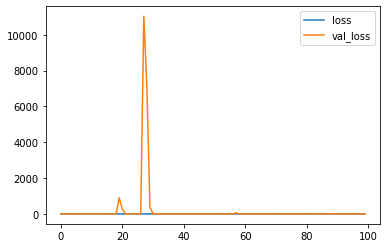

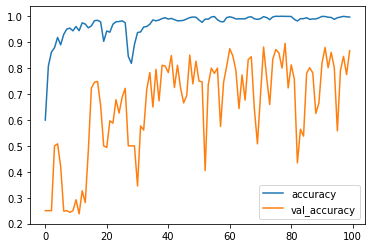

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
20/20 [==============================] - 1s 27ms/step - loss: 0.6349 - accuracy: 0.8734
test loss, test acc: [0.6348553895950317, 0.8734375238418579]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

20/20 [==============================] - 1s 24ms/step


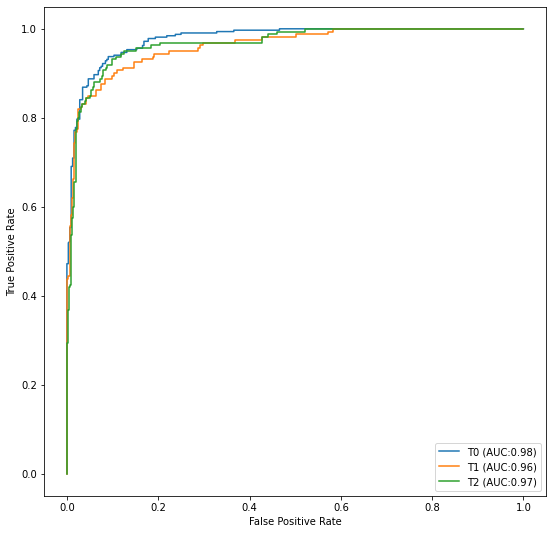

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 10s 176ms/step - loss: 0.3668 - accuracy: 0.8630 - val_loss: 78.2083 - val_accuracy: 0.2500
Epoch 2/100
30/30 [==============================] - 4s 137ms/step - loss: 0.1930 - accuracy: 0.9396 - val_loss: 7.4969 - val_accuracy: 0.2500
Epoch 3/100
30/30 [==============================] - 4s 141ms/step - loss: 0.1210 - accuracy: 0.9667 - val_loss: 1.6870 - val_accuracy: 0.5000
Epoch 4/100
30/30 [==============================] - 4s 138ms/step - loss: 0.0971 - accuracy: 0.9682 - val_loss: 2.4669 - val_accuracy: 0.2500
Epoch 5/100
30/30 [==============================] - 4s 137ms/step - loss: 0.0522 - accuracy: 0.9865 - val_loss: 9.2592 - val_accuracy: 0.2500
Epoch 6/100
30/30 [==============================] - 4s 138ms/step - loss: 0.0336 - accuracy: 0.9901 - val_loss: 7.9674 - val_accuracy: 0.2500
Epoch 7/100
30/30 [==============================] - 4s 137ms/step - loss: 0.0703 - accuracy: 0.9766 - val_loss: 2.6741 - val_accuracy: 0.25

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.366784,0.863021,78.208290,0.250000
1,0.192952,0.939583,7.496905,0.250000
2,0.121011,0.966667,1.687007,0.500000
3,0.097137,0.968229,2.466922,0.250000
4,0.052159,0.986458,9.259214,0.250000
5,0.033600,0.990104,7.967404,0.250000
6,0.070326,0.976562,2.674086,0.250000
7,0.060758,0.982292,1.265252,0.257812
8,0.056813,0.981771,7.887273,0.250000
9,0.061159,0.980729,3.308233,0.493750


Minimum validation loss: 1.2652523517608643
Maximum validation accuracy: 0.5


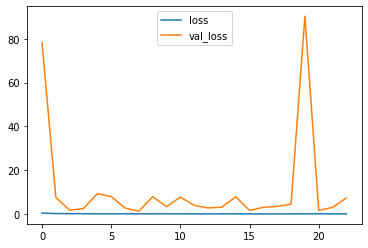

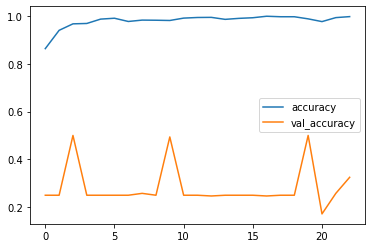

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
20/20 [==============================] - 1s 26ms/step - loss: 1.6826 - accuracy: 0.5000
test loss, test acc: [1.6825730800628662, 0.5]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

20/20 [==============================] - 1s 23ms/step


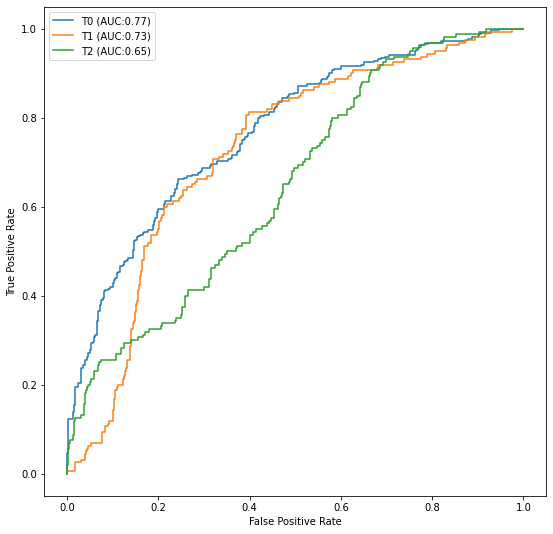

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_ResNet50_None
test loss, test acc: [0.06768157333135605, 0.981249988079071]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_ResNet50_imagenet
test loss, test acc: [0.048067107796669006, 0.9895833134651184]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_ResNet50_None
test loss, test acc: [0.6348553895950317, 0.8734375238418579]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_ResNet50_imagenet
test loss, test acc: [1.6825730800628662, 0.5]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_ResNet50_None →→→ Target Test
20/20 [==============================] - 1s 27ms/step - loss: 4.7271 - accuracy: 0.3922
test loss, test acc: [4.727120399475098, 0.3921875059604645]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_ResNet50_imagenet →→→ Target Test
20/20 [==============================] - 1s 25ms/step - loss: 4.5727 - accuracy: 0.4234
test loss, test acc: [4.5727362632751465, 0.4234375059604645]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_ResNet50_None →→→ Source Test
15/15 [==============================] - 0s 26ms/step - loss: 5.4752 - accuracy: 0.5042
test loss, test acc: [5.475192070007324, 0.5041666626930237]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_ResNet50_imagenet →→→ Source Test
15/15 [==============================] - 0s 26ms/step - loss: 1.7420 - accuracy: 0.5000
test loss, test acc: [1.7419688701629639, 0.5]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
